In [2]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod2 as SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import functions as fnc
from importlib import reload
import gc
from skimage.measure import label, regionprops
from collections import Counter
from torchvision.ops.boxes import batched_nms
from sklearn.neighbors import KDTree
import matplotlib.colors as mcolors
import os
import time
from skimage.morphology import binary_dilation
import json
import sys
from tqdm import tqdm
import pandas as pd

In [19]:
#load image
init_para={
      'DataDIR': '/DATA/vito/data/',
      'DatasetName': 'Ravi/*',
      'fid': 4,
      'crop_size': 1024,
      'resample_factor': 1,
      'dilation_size':15,
      'min_size_factor':0.001
      }

DataDIR=init_para.get('DataDIR')
DSname=init_para.get('DatasetName')
if init_para.get('fid')==None:
    if not os.path.exists(init_para.get('DataDIR')+init_para.get('DatasetName')[:-1]):
        print('Input directory does not exist. Exiting script.')
        sys.exit()
    fn_img = glob.glob(init_para.get('DataDIR')+init_para.get('DatasetName'))
    fn_img.sort()
    for i,fn in enumerate(fn_img):
        print(i, ': ', fn)
    print('--------------')
    while True:
        try:
            user_input = int(input("Please select an image: "))
            print(f"{fn_img[user_input]} selected")
            init_para.update({'fid':user_input})
            break  # Exit the loop if the input is valid
        except ValueError:
            print("Requires an index. Please try again.")
fid=init_para.get('fid')
resample_factor=init_para.get('resample_factor')

#setup SAM
MODEL_TYPE = "vit_h"
DEVICE, CHECKPOINT_PATH=fnc.set_sam(MODEL_TYPE, DataDIR)

image=fnc.load_image(DataDIR,DSname,fid)
print('Image size:', image.shape)

Currently running on GPU
Model vit_h
Ravi4_orthomosaic_clip_02mm.tif imported
Image size: (17592, 21739, 3)


In [20]:
DIR='/DATA/vito/data/Ravi/label/Ravi4/'
points=pd.read_csv(DIR+'Points_added.csv')

In [21]:
id_mask = np.zeros_like(image[:,:,0], dtype=np.uint16)
#clear gpu ram and setup sam


area=[]
for i in tqdm(range(len(points)), leave=False):
    crop_size=1024
    centroid=points.iloc[i][1:3].values
    y0, x0 =centroid
    y0, x0 = int(y0*2),int(x0*2)
    xmin,ymin=x0-crop_size/2,y0-crop_size/2
    ji=xmin/crop_size
    ii=ymin/crop_size
    if ji<0:
        ji=0
    if ii<0:
        ii=0

    #prepare image
    pre_para={'Crop': {'crop size': crop_size, 'j':ji,'i':ii}}
    temp_image=fnc.preprocessing_roulette(image, pre_para)

    #clear gpu ram and setup sam
    gc.collect()
    torch.cuda.empty_cache()
    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
    sam.to(device=DEVICE)
    predictor = SamPredictor(sam)
    predictor.set_image(temp_image)

    input_point = np.array([[int(x0-xmin),int(y0-ymin)]])
    input_label = np.array([1])

    gc.collect()
    torch.cuda.empty_cache()

    partmasks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,)
    best_idx=np.argmax(scores)#pick the mask with highest score
    mask=partmasks[best_idx].astype('bool')
    mask=fnc.clean_mask(mask)
            
    #for mask in void_pointed_reseg:
    if not (np.any(mask[0]==1) or np.any(mask[-1]==1) or np.any(mask[:,0]==1) or np.any(mask[:,-1]==1)):
        counts = np.sum(mask)
        area.append(counts*(0.2*0.2))
        resize=np.zeros(image.shape[:-1])
        Valid_area=resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)].shape
        if Valid_area==(crop_size,crop_size):
            resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)]=mask
        else:
            resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)]=mask[:Valid_area[0],:Valid_area[1]]
        #resize=fnc.resample_fnc(resize,{'target_size':image.shape[:-1][::-1]}).astype('bool')
        id_mask[resize.astype('bool')] = i
    else:
        crop_size=2048
        xmin,ymin=x0-crop_size/2,y0-crop_size/2
        ji=xmin/crop_size
        ii=ymin/crop_size
        if ji<0:
            ji=0
        if ii<0:
            ii=0

        #prepare image
        pre_para={'Crop': {'crop size': crop_size, 'j':ji,'i':ii}}
        temp_image=fnc.preprocessing_roulette(image, pre_para)

        #clear gpu ram and setup sam
        gc.collect()
        torch.cuda.empty_cache()
        sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
        sam.to(device=DEVICE)
        predictor = SamPredictor(sam)
        predictor.set_image(temp_image)

        input_point = np.array([[int(x0-xmin),int(y0-ymin)]])
        input_label = np.array([1])

        gc.collect()
        torch.cuda.empty_cache()

        partmasks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,)
        best_idx=np.argmax(scores)#pick the mask with highest score
        mask=partmasks[best_idx].astype('bool')
        mask=fnc.clean_mask(mask)
                
        #for mask in void_pointed_reseg:
        if not (np.any(mask[0]==1) or np.any(mask[-1]==1) or np.any(mask[:,0]==1) or np.any(mask[:,-1]==1)):
            counts = np.sum(mask)
            area.append(counts*(0.2*0.2))
            resize=np.zeros(image.shape[:-1])
            Valid_area=resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)].shape
            if Valid_area==(crop_size,crop_size):
                resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)]=mask
            else:
                resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)]=mask[:Valid_area[0],:Valid_area[1]]
            #resize=fnc.resample_fnc(resize,{'target_size':image.shape[:-1][::-1]}).astype('bool')
            id_mask[resize.astype('bool')] = i
        else:
            area.append(0)

  0%|          | 0/113 [00:00<?, ?it/s]/DATA/vito/.venv/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

In [22]:
len(area)

113

In [23]:
np.array(area)

array([ 683.2 ,  384.2 , 1046.56,   42.24,  295.  ,  233.52,  281.68,
        463.28,  844.72,  119.4 ,  378.28,  244.48,  227.8 ,  787.12,
        495.76,  352.04,  347.48,  327.64,  277.96,  338.32,  330.4 ,
        259.  ,  297.8 ,  285.76,  302.44,  244.16,  341.84,  296.68,
        179.04,  268.04,  263.64,  270.48,  377.4 ,  213.96,  236.32,
        310.28,  141.4 ,  323.6 ,  266.96,  222.52,  273.76,  309.96,
        308.44,  287.44,  323.36,  185.44,  193.44,  121.6 ,  336.  ,
        168.76,  298.04,  325.68,  246.  ,  309.6 ,  219.72,  304.8 ,
        229.92,  356.76,  342.2 ,  212.24,  332.48,  400.88,  381.08,
        190.84,  245.84,  335.56,  304.  ,  332.08,  397.12,  347.76,
        246.28,  221.04,  227.76,  200.36,  209.08,  357.32,  307.48,
        251.84,  223.08,  252.2 ,  379.32,  169.48,  225.72,  235.04,
        332.  ,  322.08,  226.24,  294.4 ,  322.32,  379.08,  300.12,
        354.68,  175.88,  215.8 ,  294.6 ,  316.36,  218.76,  194.92,
        119.4 ,  110

In [25]:
np.save(DIR+'FN_mask',id_mask)
np.save(DIR+'FN_area',area)

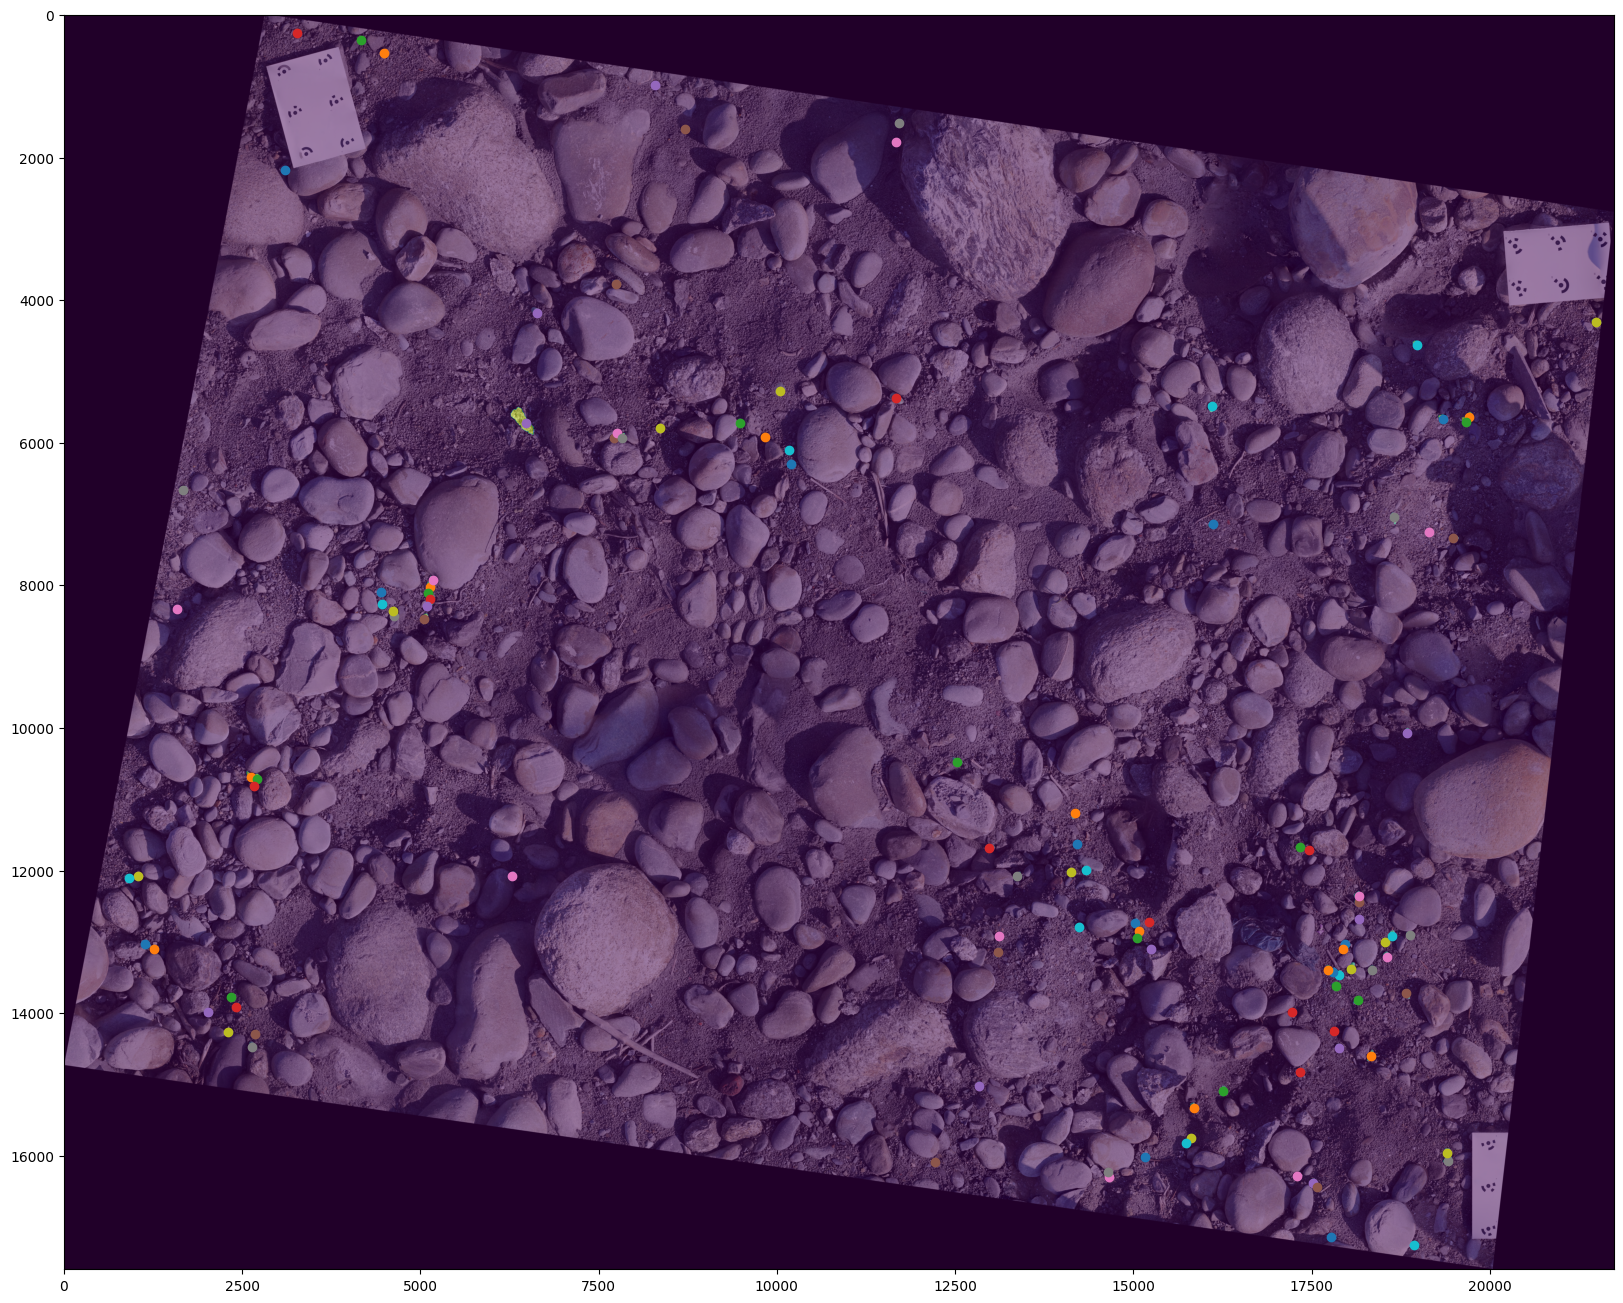

In [26]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.imshow(id_mask,alpha=0.5)
for i in range(len(points)):
    centroid=points.iloc[i][1:3].values
    y0, x0 =centroid
    y0, x0 = int(y0*2),int(x0*2)
    plt.scatter(x0,y0)